# 酸度と日本酒度による日本酒の分類

## 1.日本酒物語のサイトから日本酒データをスクレイピング

https://www.sakeno.com/

# 2.取ってきたデータをクレンジング(割愛)

# 3.クレンジングしたデータを分析

## ライブラリをインポート

In [122]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import MeCab

In [2]:
sd = pd.read_csv("../data/sakemonogatari/sake_data.csv")

In [3]:
sd.head(3)

,sakecode,sakename,meigaracode,syurui,genryoumai,seimaibuai,nihonsyudo,sando,aminosando,amakardo,noutando,alcohol
0,3315,京極 原酒,1235,本醸造 原酒,NaN,NaN,4.0,1.8,NaN,-0.87,0.18,20.0
1,3317,京極 名水 純米造り,1235,純米酒,トヨニシキ、キヨニシキ（秋田県産）,55.0,3.0,1.4,NaN,-0.31,-0.52,15.5
2,3318,京極 名水 辛口,1235,本醸造,NaN,NaN,6.0,1.4,NaN,-0.59,-0.66,15.5


## 酒の名前、日本酒度、酸度のみを抽出

In [79]:
sd2 = sd[['sakename','syurui','seimaibuai','alcohol','nihonsyudo', 'sando']]

In [80]:
sd2.head(10)

,sakename,syurui,seimaibuai,alcohol,nihonsyudo,sando
0,京極 原酒,本醸造 原酒,NaN,20.0,4.0,1.8
1,京極 名水 純米造り,純米酒,55.0,15.5,3.0,1.4
2,京極 名水 辛口,本醸造,NaN,15.5,6.0,1.4
3,京極 名水 本造り,本醸造,60.0,15.3,4.0,1.8
4,京極 カップ,NaN,NaN,15.0,4.0,1.8
5,二世古 原酒 大吟醸,原酒 大吟醸,45.0,17.5,3.0,NaN
6,二世古 吟醸酒,吟醸酒,NaN,17.5,NaN,NaN
7,二世古 純米 原酒,純米 原酒,NaN,17.5,NaN,NaN
8,二世古 蝦夷 鬼ころし 原酒,原酒,NaN,20.5,NaN,NaN
9,二世古 純米酒,純米酒,55.0,15.5,3.0,1.4


# 欠損値NaNを削除

In [81]:
sd3 = sd2.dropna()

In [82]:
sd3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4348 entries, 1 to 9205
Data columns (total 6 columns):
sakename      4348 non-null object
syurui        4348 non-null object
seimaibuai    4348 non-null float64
alcohol       4348 non-null float64
nihonsyudo    4348 non-null float64
sando         4348 non-null float64
dtypes: float64(4), object(2)
memory usage: 237.8+ KB


# indexを振り直す

In [83]:
sd3_2 = sd3.reset_index(drop=True)

In [84]:
sd3_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348 entries, 0 to 4347
Data columns (total 6 columns):
sakename      4348 non-null object
syurui        4348 non-null object
seimaibuai    4348 non-null float64
alcohol       4348 non-null float64
nihonsyudo    4348 non-null float64
sando         4348 non-null float64
dtypes: float64(4), object(2)
memory usage: 203.9+ KB


# NaNがあるかどうかを確認

In [85]:
sd3_2.isnull().any()

sakename      False
syurui        False
seimaibuai    False
alcohol       False
nihonsyudo    False
sando         False
dtype: bool

# 数値データを標準化する

In [86]:
sc = StandardScaler()

# fitでパラメータ計算

In [87]:
sc.fit(sd3_2.iloc[:,-2:])

StandardScaler(copy=True, with_mean=True, with_std=True)

# fit_transformでパラメータをもとにデータ変換

In [88]:
df_tmp = pd.DataFrame(sc.transform(sd3_2.iloc[:,-2:]))

In [89]:
df_tmp.rename(columns={0:'s_nihonsyudo', 1:'s_sando'}, inplace=True)

In [90]:
df_tmp.head(10)

,s_nihonsyudo,s_sando
0,0.067416,-0.265431
1,0.230698,0.712697
2,0.067416,-0.265431
3,0.230698,-0.754494
4,0.557263,-0.509963
5,0.720546,-0.754494
6,0.557263,-0.999026
7,0.230698,-0.754494
8,0.230698,-0.754494
9,0.393981,-0.754494


In [91]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348 entries, 0 to 4347
Data columns (total 2 columns):
s_nihonsyudo    4348 non-null float64
s_sando         4348 non-null float64
dtypes: float64(2)
memory usage: 68.0 KB


# 元のデータフレームと結合

In [92]:
sd4 = pd.concat([sd3_2,df_tmp],axis=1)

In [93]:
sd4.head(10)

,sakename,syurui,seimaibuai,alcohol,nihonsyudo,sando,s_nihonsyudo,s_sando
0,京極 名水 純米造り,純米酒,55.0,15.5,3.0,1.4,0.067416,-0.265431
1,京極 名水 本造り,本醸造,60.0,15.3,4.0,1.8,0.230698,0.712697
2,二世古 純米酒,純米酒,55.0,15.5,3.0,1.4,0.067416,-0.265431
3,柴田 純米吟醸,純米吟醸,55.0,15.5,4.0,1.2,0.230698,-0.754494
4,柴田 からくち 純米,純米酒,65.0,15.5,6.0,1.3,0.557263,-0.509963
5,柴田 からくち 本醸造,本醸造,70.0,15.5,7.0,1.2,0.720546,-0.754494
6,千歳鶴 吉翔,大吟醸,40.0,16.5,6.0,1.1,0.557263,-0.999026
7,千歳鶴 柴田與次右衛門,純米吟醸,55.0,14.5,4.0,1.2,0.230698,-0.754494
8,千歳鶴 芳翔,吟醸,55.0,15.5,4.0,1.2,0.230698,-0.754494
9,千歳鶴 雪原の舞,大吟醸,40.0,15.5,5.0,1.2,0.393981,-0.754494


In [94]:
sd4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348 entries, 0 to 4347
Data columns (total 8 columns):
sakename        4348 non-null object
syurui          4348 non-null object
seimaibuai      4348 non-null float64
alcohol         4348 non-null float64
nihonsyudo      4348 non-null float64
sando           4348 non-null float64
s_nihonsyudo    4348 non-null float64
s_sando         4348 non-null float64
dtypes: float64(6), object(2)
memory usage: 271.8+ KB


# 4クラスタでk-means法を適用

In [95]:
km = KMeans(n_clusters=4)

# 標準化した日本酒度と酸度を用いる

In [96]:
sd4.iloc[:,-2:].head(10)

,s_nihonsyudo,s_sando
0,0.067416,-0.265431
1,0.230698,0.712697
2,0.067416,-0.265431
3,0.230698,-0.754494
4,0.557263,-0.509963
5,0.720546,-0.754494
6,0.557263,-0.999026
7,0.230698,-0.754494
8,0.230698,-0.754494
9,0.393981,-0.754494


# クラスタリング実行

In [97]:
km.fit(sd4.iloc[:,-2:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# 4クラスタそれぞれの重心の確認

In [98]:
km.cluster_centers_

array([[ 0.11799481, -0.41893665],
       [-3.98198851,  1.40691856],
       [ 0.07309637,  0.66044711],
       [-8.56614297,  8.16072959]])

## 各データが所属するクラスタ番号をデータフレームに格納

In [99]:
sd4['cluster'] = km.labels_

In [100]:
sd4.head(10)

,sakename,syurui,seimaibuai,alcohol,nihonsyudo,sando,s_nihonsyudo,s_sando,cluster
0,京極 名水 純米造り,純米酒,55.0,15.5,3.0,1.4,0.067416,-0.265431,0
1,京極 名水 本造り,本醸造,60.0,15.3,4.0,1.8,0.230698,0.712697,2
2,二世古 純米酒,純米酒,55.0,15.5,3.0,1.4,0.067416,-0.265431,0
3,柴田 純米吟醸,純米吟醸,55.0,15.5,4.0,1.2,0.230698,-0.754494,0
4,柴田 からくち 純米,純米酒,65.0,15.5,6.0,1.3,0.557263,-0.509963,0
5,柴田 からくち 本醸造,本醸造,70.0,15.5,7.0,1.2,0.720546,-0.754494,0
6,千歳鶴 吉翔,大吟醸,40.0,16.5,6.0,1.1,0.557263,-0.999026,0
7,千歳鶴 柴田與次右衛門,純米吟醸,55.0,14.5,4.0,1.2,0.230698,-0.754494,0
8,千歳鶴 芳翔,吟醸,55.0,15.5,4.0,1.2,0.230698,-0.754494,0
9,千歳鶴 雪原の舞,大吟醸,40.0,15.5,5.0,1.2,0.393981,-0.754494,0


In [101]:
df_sct = []

# 4クラスタを4色に色分けする

In [102]:
color_list = ['r','b','g','y']

In [103]:
for i in [0,1,2,3]:
    df_sct.append(sd4[sd4['cluster']==i])

In [104]:
fig = plt.figure()

In [105]:
ax = fig.add_subplot(1,1,1)

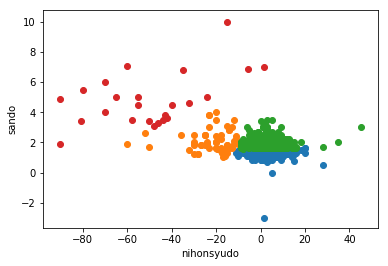

In [106]:
for df_tmp,color in zip(df_sct,color_list):
    plt.scatter(x=df_tmp.iloc[:,-5],y=df_tmp.iloc[:,-4])
    
plt.xlabel("nihonsyudo")
plt.ylabel("sando")

In [107]:
cluster0 = sd4[sd4['cluster']==0]
cluster1 = sd4[sd4['cluster']==1]
cluster2 = sd4[sd4['cluster']==2]
cluster3 = sd4[sd4['cluster']==3]

## クラスタ0の分析

In [118]:
cluster0.sakename

0              京極 名水 純米造り
2                 二世古 純米酒
3                 柴田 純米吟醸
4              柴田 からくち 純米
5             柴田 からくち 本醸造
6                  千歳鶴 吉翔
7             千歳鶴 柴田與次右衛門
8                  千歳鶴 芳翔
9                千歳鶴 雪原の舞
10               北の錦 三年古酒
12              北の錦 北海278
13          雪氷室 一夜雫 大吟醸原酒
14          雪氷室 一夜雫 大吟醸清酒
15               国士無双 大吟醸
16                 国士無双 烈
17                  金滴 徳富
18                金滴 微笑一献
19                 国稀 大吟醸
20                国稀 吟醸原酒
21                 国稀 吟醸酒
22           国稀 吟醸酒 雪のかおり
24           国稀 本醸造 暑寒おろし
26             国稀 北海 鬼ころし
27                 国稀 本醸造
28          国稀 本醸造 建築物ラベル
29                  国稀 上撰
30                大雪乃蔵 鳳雪
31                大雪乃蔵 純米
32               大雪乃蔵 本醸造
33                大雪乃蔵 絹雪
              ...        
4308            香露 特撰 本醸造
4309            香露 上撰 本醸造
4310            香露 くまもとの酒
4311             朱盃 純米大吟醸
4312        朱盃 特別純米酒 黒ラベル
4313               朱盃 純米酒
4314             泰斗 特別本醸造
4315        

In [124]:
m = MeCab.Tagger ("-Ochasen")
print (m.parse("すもももももももものうち"))

すもも	スモモ	すもも	名詞-一般		
も	モ	も	助詞-係助詞		
もも	モモ	もも	名詞-一般		
も	モ	も	助詞-係助詞		
もも	モモ	もも	名詞-一般		
の	ノ	の	助詞-連体化		
うち	ウチ	うち	名詞-非自立-副詞可能		
EOS



In [74]:
cluster0.syurui.value_counts()

大吟醸                   553
純米吟醸                  498
純米大吟醸                 344
本醸造                   310
純米酒                   298
特別純米酒                 149
吟醸                    131
普通酒                   125
特別本醸造                 109
吟醸酒                   102
大吟醸 原酒                 26
純米吟醸 無濾過 生原酒           20
大吟醸原酒                  17
純米                     16
原酒                     14
にごり酒                   13
純米吟醸原酒                 13
特別純米                   12
純米吟醸 生酒                12
大吟醸古酒                  12
本醸造 生貯蔵酒               12
純米吟醸酒                  11
純米吟醸 生原酒               10
純米大吟醸 原酒               10
大吟醸 古酒                  8
純米吟醸 原酒                 8
純米大吟醸 無濾過 生原酒           7
純米大吟醸 生原酒               7
生貯蔵酒                    7
吟醸原酒                    7
                     ... 
大吟醸純米酒                  1
純米吟醸にごり酒                1
純米吟醸 吊雫原酒               1
三年熟成純米大吟醸               1
特別本醸造（吟醸酒を25%ブレンド）      1
純米吟醸 無ろ過 生原酒            1
純米吟醸生貯蔵酒                1
掛米：50%、麹米：50

In [108]:
cluster0.mean()['seimaibuai'] 

51.249651324965136

In [109]:
cluster0.mean()['alcohol'] 

15.961907252440753

## クラスタ1の分析

In [119]:
cluster1.sakename

69                        三戸のどんべり 純米にごり酒
93                            陸奥八仙 どぶろっく
199        あさ開 SILVER MOON -TEN YEARS IT
240                             雪っこ 活性原酒
285                        南部美人 All Koji
584                    天上夢幻 純米吟醸 濁酒 カメ入り
892                          出羽ノ雪 貴醸酒 醴酒
1086                         自然酒（福島県） 特撰
1087                       自然酒（福島県） 生しぼり
1089                              金寶 穂の歌
1106             奥の松 純米大吟醸 プレミアム スパークリング
1108                        奥の松 純米大吟醸 FN
1134                   奥の松 純米大吟醸 スパークリング
1178                             末廣 にごり酒
1185                        末廣 微発泡酒 ぷちぷち
1200                   弥右衛門 カスモチ原酒 弥右衛門酒
1330                            旭興 貴醸酒 百
1355                    華囲香 特別純米酒 桃色にごり酒
1606                        秩父錦 荒しぼり 濁り酒
1655                          東魁盛 夏 純米吟醸
1827                    ゆきくら スパークリング大吟醸酒
1929                          八海山 発泡にごり酒
1936                             八海山 貴醸酒
1943                           越 純米吟醸 柔口
1951            

In [76]:
cluster1.syurui.value_counts()

純米吟醸                  10
にごり酒                   9
純米酒                    6
純米 にごり酒                4
特別純米酒                  3
本醸造                    3
原酒                     2
純米酒 にごり酒               2
にごり酒 原酒                2
貴醸酒                    2
純米酒 原酒                 2
微発泡酒                   2
純米大吟醸 スパークリング          2
大吟醸                    1
純米 無濾過 生原酒             1
特別純米酒 無濾過 生原酒          1
純米                     1
活性原酒                   1
純米吟醸 古酒                1
純米 活性にごり               1
どぶろく                   1
純米吟醸 生酒                1
伝承水酛仕込み どぶろく           1
本醸造 にごり酒               1
純米酒 無濾過 生原酒            1
純米吟醸酒                  1
本醸造 原酒                 1
にごり酒 発泡清酒              1
生 にごり酒 原酒              1
普通酒（にごり酒）              1
発泡性 純米にごり              1
純米吟醸 原酒                1
にごり酒 普通酒               1
純米生原酒                  1
純米吟醸 低温長期発酵            1
全麹純米酒                  1
純米 にごり酒                1
にごり酒 活性清酒              1
純米酒 生酒                 1
特別純米にごり酒               1


In [110]:
cluster1.mean()['seimaibuai'] 

61.762711864406782

In [111]:
cluster0.mean()['alcohol'] 

15.961907252440753

## クラスタ2の分析

In [120]:
cluster2.sakename

1                    京極 名水 本造り
11                     北の錦 まる田
23                    国稀 特別純米酒
25                  国稀 北海 にごり酒
40         北の誉 純米大吟醸酒 鰊御殿 夏季限定
41         北の誉 季節限定 特別純米 ひやおろし
46                   北の誉 純米 心白
48          北の誉 ほしのゆめ100%使用 純米
55          男山（北海道） 特別純米 ひやおろし
56               男山（北海道） 生酛 純米
57                 男山（北海道） 御免酒
72                八鶴 純米大吟醸 華想い
74                     八鶴 純米吟醸
75                    八鶴 SAKE8
76           八鶴 純米吟醸 無ろ過生 はちつる
77              八鶴 濃醇超辛 純米酒 剛酒
78                      八鶴 純米酒
82                   陸奥田心 純米吟醸
84              陸奥八仙 純米吟醸 黒ラベル
85                   陸奥八仙 芳醇超辛
87             陸奥八仙 特別純米酒 赤ラベル
88      陸奥八仙  吟醸 あらばしり シルバーラベル
89             陸奥八仙 特別純米酒 青ラベル
90       陸奥八仙 特別純米酒 ひやおろし 緑ラベル
92          陸奥八仙 特別純米酒 いさり火ラベル
95               陸奥男山 超辛純米 裏男山
96                    陸奥男山 生一本
100           鳩正宗 純米大吟醸 山田錦 48
101        鳩正宗 Crystal of snow
107                    亀吉 純米吟醸
                 ...          
4226                智恵美人 純米大吟醸
4227    

In [77]:
cluster2.syurui.value_counts()

純米酒                   294
純米吟醸                  288
特別純米酒                 127
純米大吟醸                 106
本醸造                    55
純米吟醸 原酒                27
純米吟醸 無濾過 生原酒           26
大吟醸                    22
吟醸                     17
純米酒 原酒                 16
普通酒                    15
純米生原酒                  12
純米                     11
山廃 純米酒                 10
吟醸酒                    10
山廃純米酒                  10
山廃純米                    9
山廃 純米吟醸                 9
純米大吟醸 無濾過 生原酒           9
純米吟醸 生原酒                9
純米酒 無濾過 生原酒             8
純米吟醸生原酒                 8
純米原酒                    8
純米酒 ひやおろし               8
特別本醸造                   7
純米大吟醸 生原酒               6
純米酒 生原酒                 6
純米 無濾過 生原酒              6
純米吟醸原酒                  6
純米吟醸 中取り 無濾過 生原酒        5
                     ... 
山廃純米 十年古酒               1
純米大吟醸 無濾過生酒             1
にごり酒活性原酒                1
純米吟醸 長期貯蔵酒              1
純米発砲にごり酒                1
特別純米生原酒                 1
純米酒 原酒 ひやおろし            1
純米酒 槽場直汲 無濾過

In [112]:
cluster2.mean()['seimaibuai'] 

55.775948460987834

In [113]:
cluster2.mean()['alcohol'] 

16.41794559770937

## クラスタ3の分析

In [121]:
cluster3.sakename

62             男山（北海道） 復古酒
68            三戸のどんべり 初恋風味
418     ラシャンテ スパークリング 発泡清酒
639                  米米酒  
642             あ、不思議なお酒  
643               ひめぜん 純米酒
1392           松の寿 貴醸酒 山田錦
1614             むすひ 発芽玄米酒
1644               木戸泉 AFS
1645             木戸泉 純米AFS
2074    Riz Vin スパーク・リ・ヴァン
2202            真澄 スパークリング
2899             ねのひ なないろ桜
3455            明石鯛 玄米 山田錦
3468               富久錦 Ｆｕ．
3646      華鳩 貴醸酒 10年熟成 大古酒
3647         華鳩 貴醸酒 オーク樽貯蔵
3648              華鳩 貴醸酒 醞
3649        華鳩 貴醸酒 NOUVEAU
3653          音戸の瀬戸 船唄に寄せて
3803          金冠黒松 貴醸酒 黒松錦
3985              梅錦 四季香麗水
3990              桜うづまき 元禄
4257               MOMO もも
Name: sakename, dtype: object

In [78]:
cluster3.syurui.value_counts()

純米酒               5
貴醸酒               4
古酒                3
雑酒                2
一段仕込み多酸古酒         1
発泡清酒              1
純米吟醸              1
発芽玄米酒             1
一段仕込み多酸酒          1
辛口本醸造             1
壜内二次発酵 スパークリング    1
純米酒 にごり酒          1
原酒 二年熟成           1
純米 にごり酒           1
純米原酒              1
微発泡 にごり酒          1
普通酒               1
古代酒               1
発泡純米酒             1
Name: syurui, dtype: int64

In [116]:
cluster3.mean()['seimaibuai'] 

66.333333333333329

In [117]:
cluster3.mean()['alcohol'] 

12.425000000000002